<a href="https://colab.research.google.com/github/jorferr89/10-ejemplos-opencv-python/blob/main/YOLO_COCO_ReconocimientoDeObjetos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocimiento de Objetos con YOLO y COCO

### COCO -- class labels para 80 objetos

Las clases estan almacenadas en el archivo de texto `coco.names`:

In [ ]:
!cat coco.names | wc -l

80


In [ ]:
!cat coco.names

person
bicycle
car
motorbike
aeroplane
bus
train
truck
boat
traffic light
fire hydrant
stop sign
parking meter
bench
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe
backpack
umbrella
handbag
tie
suitcase
frisbee
skis
snowboard
sports ball
kite
baseball bat
baseball glove
skateboard
surfboard
tennis racket
bottle
wine glass
cup
fork
knife
spoon
bowl
banana
apple
sandwich
orange
broccoli
carrot
hot dog
pizza
donut
cake
chair
sofa
pottedplant
bed
diningtable
toilet
tvmonitor
laptop
mouse
remote
keyboard
cell phone
microwave
oven
toaster
sink
refrigerator
book
clock
vase
scissors
teddy bear
hair drier
toothbrush


## Librerías necesarias

In [ ]:
import cv2
import numpy as np
import time

from matplotlib import pyplot as plt

## Carga de la imagen de Prueba

In [ ]:
img_name = 'imagen-objetos.jpg'

# Leyendo imagen en un objeto.
img = cv2.imread(img_name)

### Conversión de colores

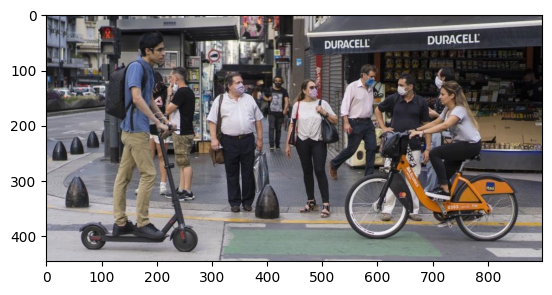

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#### Descarga del archivo `yolov3.weights`

El archivo es bastante grande, por eso se descarga para esta prueba. Debe descargar también el archivo `yolov3.cfg`

In [ ]:
!wget -O yolov3.weights https://pjreddie.com/media/files/yolov3.weights

--2024-03-15 01:54:40--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  34.9MB/s    in 7.6s    

2024-03-15 01:54:48 (31.2 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
# Cargar los nombres de las clases y obtener colores aleatorios para ellas.
classes = open('coco.names').read().strip().split('\n')

# Establecer una semilla para la generación de números aleatorios.
np.random.seed(42)

# Generar colores aleatorios para cada clase.
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')

# Dar los archivos de configuración y pesos al modelo y cargar la red.
net = cv2.dnn.readNetFromDarknet('yolov3.cfg', 'yolov3.weights')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)

# Mostrar el objeto de red.
net

< cv2.dnn.Net 0x7c12bd533730>

## Determinar la capa de salida

In [ ]:
# Obtención de los nombres de las capas
ln = net.getLayerNames()
len(ln)

254

In [ ]:
# Mostrar los nombres de todas las capas
print(ln)

('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'conv_37', 'bn_37', 'leaky_

In [ ]:
# Obtener las capas de salida
net.getUnconnectedOutLayers()

array([200, 227, 254], dtype=int32)

In [ ]:
# Mostrar los nombres de estas capas
try:
    print([ln[i[0] - 1] for i in net.getUnconnectedOutLayers()])
except IndexError:
    print([ln[i - 1] for i in net.getUnconnectedOutLayers()])

['yolo_82', 'yolo_94', 'yolo_106']


In [ ]:
# Uso
try:
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
except IndexError:
    ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

ln

['yolo_82', 'yolo_94', 'yolo_106']

Forma del blob=(1, 3, 416, 416)


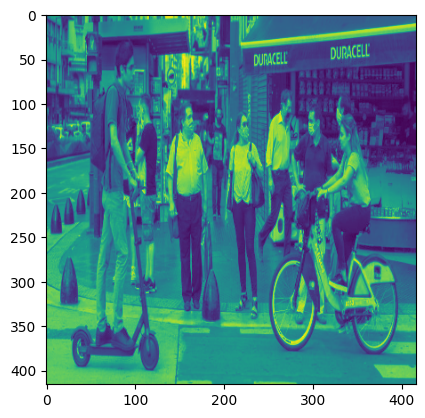

In [ ]:
# Construir un blob a partir de la imagen
blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
r = blob[0, 0, :, :]

plt.imshow(r)
print('Forma del blob=%s' % (blob.shape,))

In [ ]:
net.setInput(blob)
t0 = time.time()
outputs = net.forward(ln)
t = time.time()
print('Tiempo de procesamiento: %.3f segundos' % (t-t0))

Tiempo de procesamiento: 4.192 segundos


Los objetos de salida son vectores de longitud 85 (4 + 1 + 80):

    4x the bounding box (centerx, centery, width, height)
    1x box confidence
    80x class confidence


In [ ]:
# Imprimir el número de objetos encontrados
print('Se encontraron %s objetos.' % len(outputs))

# Imprimir los objetos enlistados
print('\nLista de objetos:')
print([out.shape for out in outputs])

Se encontraron 3 objetos.

Lista de objetos:
[(507, 85), (2028, 85), (8112, 85)]


In [ ]:
# Inicializar listas para almacenar cajas delimitadoras, confidencias y IDs de clase
boxes = []
confidences = []
classIDs = []

# Obtener la altura y anchura de la imagen
h, w = img.shape[:2]

# Iterar sobre las salidas de la red neuronal
for output in outputs:
    for detection in output:
        # Obtener las puntuaciones de las clases
        scores = detection[5:]
        # Obtener el ID de clase con la puntuación más alta
        classID = np.argmax(scores)
        # Obtener la confianza de la detección
        confidence = scores[classID]
        # Filtrar las detecciones débiles
        if confidence > 0.5:
            # Calcular las coordenadas de la caja delimitadora
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = [x, y, int(width), int(height)]
            # Agregar la caja delimitadora, confianza y ID de clase a las listas
            boxes.append(box)
            confidences.append(float(confidence))
            classIDs.append(classID)

# Aplicar supresión de no máximos para eliminar detecciones superpuestas
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
if len(indices) > 0:
    for i in indices.flatten():
        # Obtener las coordenadas de la caja delimitadora
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        # Obtener el color para la clase
        color = [int(c) for c in colors[classIDs[i]]]
        # Dibujar un rectángulo alrededor del objeto detectado
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 4)
        # Crear una fuente de texto mediana
        font = cv2.FONT_HERSHEY_SIMPLEX
        # Obtener el texto de la clase y la confianza
        text = "{}: {:.2f}".format(classes[classIDs[i]], confidences[i])
        # Dibujar el texto en la imagen
        cv2.putText(img, text, (x, y - 10), font, 0.7, color, 2, cv2.LINE_AA)

In [ ]:
# Imprimir la lista de objetos detectados junto con sus coordenadas y confianzas
for i in indices.flatten():
    print("Objeto:", classes[classIDs[i]])
    print("Coordenadas de la caja delimitadora (x, y, w, h):", boxes[i])
    print("Confianza:", confidences[i])
    print()

Objeto: person
Coordenadas de la caja delimitadora (x, y, w, h): [290, 98, 103, 266]
Confianza: 0.9988920092582703

Objeto: person
Coordenadas de la caja delimitadora (x, y, w, h): [667, 116, 127, 226]
Confianza: 0.9987592697143555

Objeto: person
Coordenadas de la caja delimitadora (x, y, w, h): [525, 93, 87, 206]
Confianza: 0.9981285333633423

Objeto: person
Coordenadas de la caja delimitadora (x, y, w, h): [431, 92, 95, 288]
Confianza: 0.9980781674385071

Objeto: person
Coordenadas de la caja delimitadora (x, y, w, h): [112, 36, 107, 357]
Confianza: 0.990888237953186

Objeto: person
Coordenadas de la caja delimitadora (x, y, w, h): [212, 92, 74, 249]
Confianza: 0.9854733943939209

Objeto: bicycle
Coordenadas de la caja delimitadora (x, y, w, h): [533, 215, 336, 202]
Confianza: 0.977167010307312

Objeto: person
Coordenadas de la caja delimitadora (x, y, w, h): [402, 114, 41, 129]
Confianza: 0.9405930042266846

Objeto: person
Coordenadas de la caja delimitadora (x, y, w, h): [600, 110

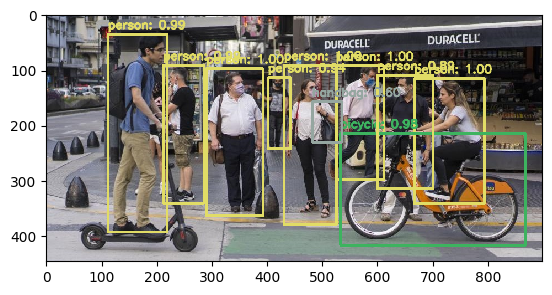

In [ ]:
# Mostrar la imagen
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation='none')